In [20]:
#hide
from utils import *
from fastai2.vision.widgets import *
import fastcore
import azure

# From model to production

## The practice of deep learning

### Starting your project

### The state of deep learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

### The Drivetrain approach

## Gathering data

To download images with Bing Image Search, you should sign up at Microsoft for *Bing Image Search*. You will be given a key, which you can either paste here, replacing "XXX":

In [2]:
key = '106a23f9cd1a4bd99bb89e80c14d338b'

Let's do something simple with image recognition. 

I want to learn more about identifying different instruments in a jazz band. 

Instruments:
* Saxophone
* Trumpet
* Trombone
* Clarinet

First step is to of course get the data. We do this by searching Bing. Let's show how this would work with a single example of Saxophone. 

The `search_images_bing` method returns by default 150 images. This is non-configurable via fastai. 

In [8]:
saxophone_results = search_images_bing(key, 'saxophone')

In [24]:
# Get the 'content_url' for every result in our bing search. Return as a new list.
saxophone_image_urls = saxophone_results.attrgot('content_url') 

In [27]:
# We download a single picture as a test. 
sample_sax_path = 'images/sax_1.jpg'
download_url(saxophone_image_urls[2], sample_sax_path)

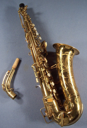

In [29]:
# Open the image and inspect. 
sample_sax = Image.open(sample_sax_path)
sample_sax.to_thumb(128, 128)

In [30]:
instruments = ['saxophone', 'trumpet', 'trombone', 'clarinet']
path = Path('jazz_instruments') 

In [35]:
if not path.exists():
    path.mkdir()

In [37]:
# Populate the subdirectories
for i in instruments:
    dest = (path/i)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, i)
    download_images(dest, urls=results.attrgot('content_url'))

In [38]:
file_names = get_image_files(path)
file_names

(#594) [Path('jazz_instruments/trombone/00000045.jpg'),Path('jazz_instruments/trombone/00000047.jpg'),Path('jazz_instruments/trombone/00000132.jpg'),Path('jazz_instruments/trombone/00000084.jpg'),Path('jazz_instruments/trombone/00000029.jpg'),Path('jazz_instruments/trombone/00000043.jpg'),Path('jazz_instruments/trombone/00000113.jpg'),Path('jazz_instruments/trombone/00000063.jpg'),Path('jazz_instruments/trombone/00000065.jpg'),Path('jazz_instruments/trombone/00000004.jpg')...]

In [40]:
failed = verify_images(file_names)

/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2703: UserWarning: image file could not be identified because WEBP support not installed
  war

(#27) [Path('jazz_instruments/trombone/00000048.jpg'),Path('jazz_instruments/trombone/00000034.jpg'),Path('jazz_instruments/trombone/00000090.jpg'),Path('jazz_instruments/trombone/00000022.jpg'),Path('jazz_instruments/trombone/00000094.jpg'),Path('jazz_instruments/trombone/00000080.jpg'),Path('jazz_instruments/trombone/00000088.jpg'),Path('jazz_instruments/trombone/00000049.jpg'),Path('jazz_instruments/trombone/00000089.jpg'),Path('jazz_instruments/saxophone/00000035.jpg')...]

In [43]:
failed.map(Path.unlink);

In [44]:
??Path.unlink

### Sidebar: Getting help in jupyter notebooks

### End sidebar

## From data to DataLoaders

DataBlock.

We need some sort of interface to work with our data. 

What each argument means: 
* Blocks: specify the independent and dependent variables. 
  * Independent variables are the raw data. It's what is being used to predict the depdendent variable. It's the input to our model. 
  * Dependent variables is what we're trying to predict. 
* `get_items`: how do we get the independent variables? This could probably be renamed get_x. 
* Splitter
  * How do we want to split our items i.e. our independent variables into training and validation?
* `get_y`: how do we get the dependent variables? 
* `item_tfms`: what transformation do you want to apply to your independent variables? When doing tensor computation, all of the images need to be of the same size. 

In [47]:
instruments = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

I guess something I don't understand well is why is `DataLoaders` hierarchically "under" a `DataBlock`? 

They explain that a `DataBlock` is like a template for a `DataLoaders`. 
  * Something like this would make more sense to me I feel (new DataLoaders(DataBlock)). 

In [48]:
instrument_dataloaders = instruments.dataloaders(path)

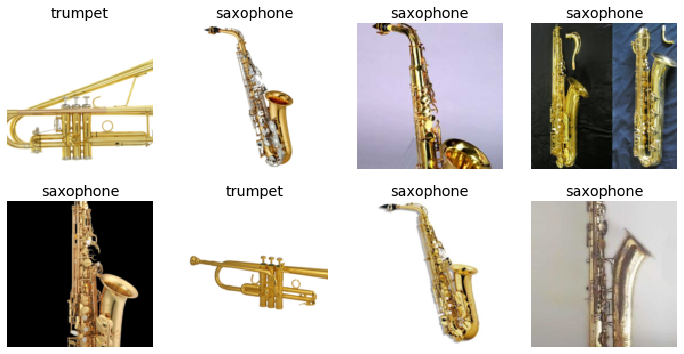

In [54]:
# How would having a picture with multiple saxophones in it affect our model's ability to identify a single saxophone? 
instrument_dataloaders.valid.show_batch(max_n=4, nrows=2)

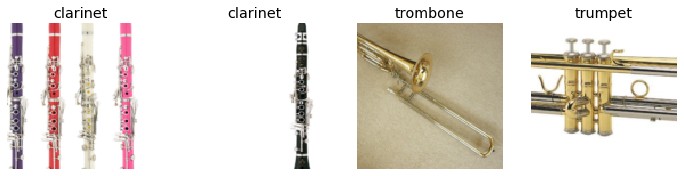

In [58]:
# Copy this DataBlock but change a parameter
instruments = instruments.new(item_tfms=RandomResizedCrop(128, min_scale=0.3)) 
instrument_dls = instruments.dataloaders(path) # It still feels weird to me why a DataLoader would only have a single parameter
instrument_dls.train.show_batch(max_n=4, nrows=1)

For the `.get_idxs` method, you define how to "get the next" item. If you feed a list that has all of the same values, then it will return the same image. 

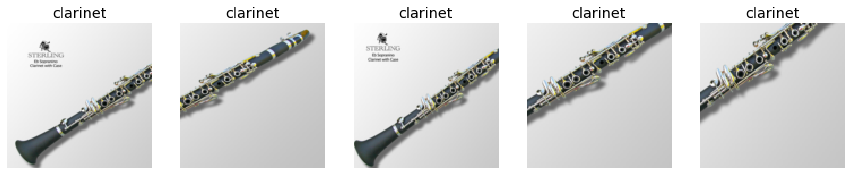

In [59]:
instruments = instruments.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = instruments.dataloaders(path)
dls.train.get_idxs = lambda: itertools.cycle([9])
dls.train.show_batch(max_n=5, nrows=1)

### Data augmentation

Create random variations of our input data so that they're different but don't change the meaning. In a way this is like generating artificial noise and making our model more robust wrt certain fluctuations in the data. 

What does the `mult` parameter do exactly? --> do x-times the amount of distortion/augmentation.

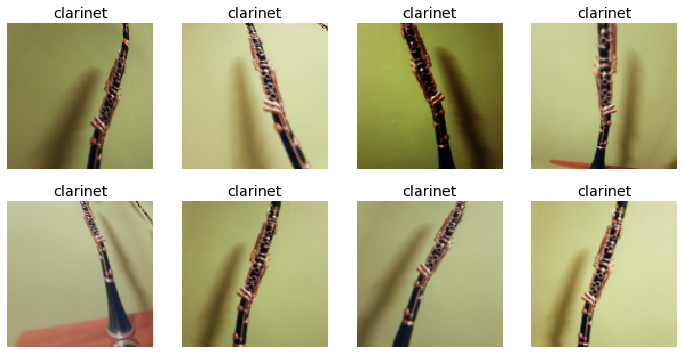

In [81]:
instruments = instruments.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = instruments.dataloaders(path)
dls.train.get_idxs = lambda: Inf.ones
dls.train.show_batch(max_n=8, nrows=2)

## Training your model, and using it to clean your data

It basically feels like we build all of our transformations into our Data Loaders object (which then applies it to all independent variables). It's actually quite useful to couple all of these things together. 

I also like how they iteratively built up the logic behind all of the different transformations. 

At the end of the day, we should: 
1) Standardize the image sizes
2) Crop different parts of our images (to lower the risk of 'out of domain' data) 
3) Augment the data by applying various transforms (to further lower the risk of 'out of domain' data)
  - I think data augmentation gives a lot of room for creativity. We need to think about all the different kinds of data that our model could see. At the same time though, we're not omniscient - we can't think of all possible scenarios. Is there a way to systemically go through all of these different scenarios to minimize the risk of 'out of domain' data? 

In [82]:
instruments = instruments.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), # 224 px is a standard size for image classification 
    batch_tfms=aug_transforms())
dls = instruments.dataloaders(path)

And now we do the actual model training. 

We use the `fine_tune` method since we're doing transfer learning. (i.e. using a pre-trained model).

This line of code is super loaded and definitely deserves revisiting. 

In [83]:
# We pass in the dataloaders object to our learner. 
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.065565,0.650960,0.242604,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.431449,0.154219,0.053254,00:06
1,0.312205,0.048501,0.023669,00:06
2,0.240546,0.041891,0.023669,00:06
3,0.192812,0.035632,0.017751,00:05
4,0.161253,0.037137,0.023669,00:05


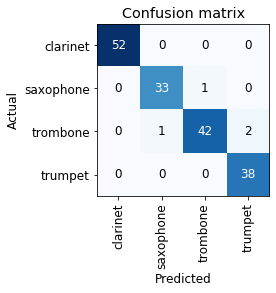

In [84]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Some conclusions based on this confusion matrix: 
- Our model is strong at identifying clarinets. 
- It's somewhat strong at identifying saxophones - only missing 1. 
- It's quite weak at identifying trombones - misclassifying 5 of them as trumpets. 
- And it's somewhat strong at identifying trumpets, only misclassifying 2 of them. 

BUT, the tendency to misclassify trombones as trumpets is super apparent. 
* Does this technically mean that our model is bad at classifying trumpets as well? (since it can't distinguish that well?) 

**How do we interpret a confusion matrix correctly?** 

This is 'plot top losses' visualization is really interesting actually.

For a lot of the incorrect classifications, it's because there are multiple instruments in the picture...

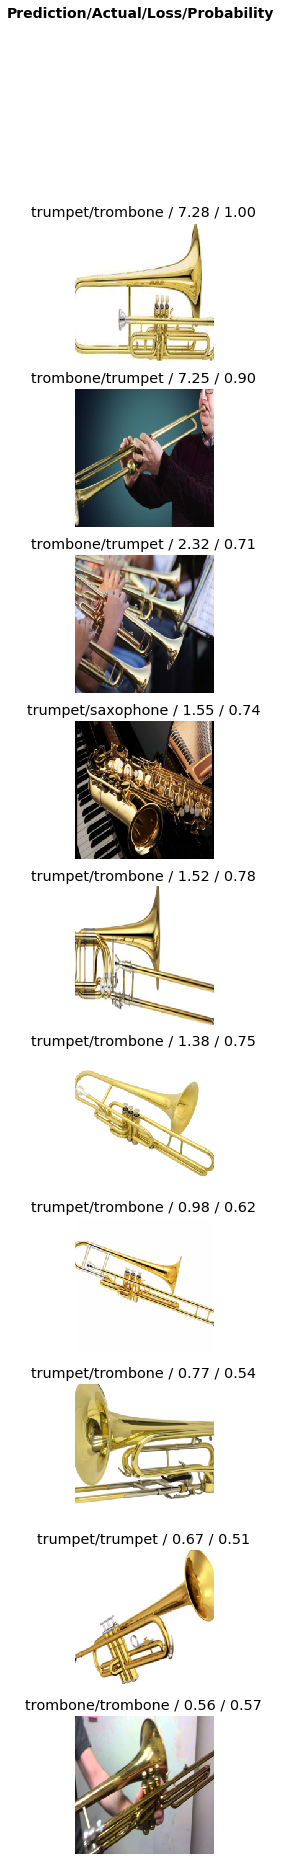

In [77]:
interp.plot_top_losses(10, nrows=10)

In [78]:
cleaner = ImageClassifierCleaner(learn)
cleaner

If you modify any files, you have to remake the data loaders object. 

In [79]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(cleaner.fns[idx], path/cat)

## Turning your model into an online application

### Using the model for inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([9.0767e-06, 9.9999e-01, 1.5748e-07]))

In [ ]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

### Creating a Notebook app from the model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning your notebook into a real app

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila --sys-prefix

### Deploying your app

## How to avoid disaster

### Unforeseen consequences and feedback loops

## Get writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly, due to structural or style differences to the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain approach?
1. How do the steps of the Drivetrain approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between crop, pad, and squish resize approaches? When might you choose one over the other?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are 3 examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out of domain data"?
1. What is "domain shift"?
1. What are the 3 steps in the deployment process?
1. For a project you're interested in applying deep learning to, consider the thought experiment "what would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.

In [ ]:
1. 
2. Text models are bad at providing accurate information? 
3. Fake content generation 
4. 

### Further research

1. Consider how the Drivetrain approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?